<a href="https://colab.research.google.com/github/anasali0006/Fire-and-Smoke-Detection-Transfer-Learning/blob/main/Fiire_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## 1.   Importing Google Drive into Colab 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Getting the Training Data from Google Drive

In [ ]:
!unzip -q /content/drive/'My Drive'/'FinalFire.zip' -d Fire
!unzip -q /content/drive/'My Drive'/'FinalNonfire.zip' -d Fire

## 3. Installing Tensorflow 2.1.0

In [ ]:
pip uninstall tensorflow

Uninstalling tensorflow-2.3.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.3.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.3.0


In [ ]:
pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 30kB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 450kB 36.8MB/s 
     |████████████████████████████████| 3.9MB 37.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=bd5d401b0a09b19d2280003f2bfc34b2d9561c566a7fca31300b93f0dc24a196
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninsta

In [ ]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())

2.1.0
/device:GPU:0


In [ ]:
import tensorflow as tf 
from tensorflow import keras
from PIL import Image
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


## 4. Loading the Test Data

In [ ]:
import cv2
import sys
from imutils import paths

FIRE_PATH='/content/Fire/Fire'
NON_FIRE_PATH='/content/Fire/Nonfire'

def load_dataset(datasetPath):
	# grab the paths to all images in our dataset directory, then
	# initialize our lists of images
	imagePaths = list(paths.list_images(datasetPath))
	data = []

	# loop over the image paths
	for imagePath in imagePaths:
		# load the image and resize it to be a fixed 128x128 pixels,
		# ignoring aspect ratio
		image = cv2.imread(imagePath)
		image = cv2.resize(image, (128,128))

		# add the image to the data lists
		data.append(image)

	# return the data list as a NumPy array
	return np.array(data, dtype="float32")



# load the fire and non-fire images
print("[INFO] loading data...")
fireData = load_dataset( FIRE_PATH)
nonFireData = load_dataset( NON_FIRE_PATH)
print("[INFO] Completed")

[INFO] loading data...
[INFO] Completed


## 5. (CorssValidation)Test-Train Split

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# initialize the class labels in the dataset
CLASSES = ["Non-Fire", "Fire"]

# define the size of the training and testing split
TRAIN_SPLIT = 0.90
TEST_SPLIT = 0.10

# define the initial learning rate, batch size, and number of epochs
INIT_LR = 1e-2
BATCH_SIZE = 100
NUM_EPOCHS = 50


SAMPLE_SIZE = 50


print(fireData.shape)
print(nonFireData.shape)



# construct the class labels for the data
fireLabels = np.ones((fireData.shape[0],))
nonFireLabels = np.zeros((nonFireData.shape[0],))
# stack the fire data with the non-fire data, then scale the data
# to the range [0, 1]
data = np.vstack([fireData, nonFireData])
labels = np.hstack([fireLabels, nonFireLabels])



data /= 255
# perform one-hot encoding on the labels and account for skew in the
# labeled data
labels = to_categorical(labels, num_classes=2)
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals



# construct the training and testing split
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size= TEST_SPLIT, random_state=42)
print(trainX.shape)

(7553, 128, 128, 3)
(3650, 128, 128, 3)
(10082, 128, 128, 3)


## 6. Observing the Data

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainX[i], cmap=plt.cm.binary)
    if trainY[i][0] == 1:
      plt.xlabel("Non-Fire")
    else:
      plt.xlabel("Fire")

plt.show()

# 7. Model 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D

from tensorflow.keras.applications import Xception

base_model=Xception(include_top=False, input_shape=(128,128,3), weights='imagenet')
base_model.trainable=False
#print(base_model.summary())
input_image=Input(shape=(128,128,3))
x=base_model(input_image, training=False)

x=Flatten()(x)
x=keras.layers.Dense(2048,activation="relu")(x)
x = Dropout(0.3)(x)
x=keras.layers.Dense(2048,activation="relu")(x)
x = Dropout(0.3)(x)
x=keras.layers.Dense(1024,activation="relu")(x)
x = Dropout(0.3)(x)
x=keras.layers.Dense(1024,activation="relu")(x)
x = Dropout(0.3)(x)
x=keras.layers.Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = keras.layers.Dense(2, activation='softmax')(x)
model = keras.Model(input_image, outputs)


In [ ]:
print(model.summary())

# 8. This part is for Fine-Tuning after the Transfer Learning Model is trained on our data

In [ ]:
NUM_EPOCHS=100
INIT_LR=0.0001
base_model.trainable=True


# 9. Training the Top layers of Model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

# initialize the training data augmentation object
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(learning_rate= INIT_LR)
#opt = SGD(lr= INIT_LR, momentum=0.9)
#	decay= INIT_LR /  NUM_EPOCHS)


model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# check to see if we are attempting to find an optimal learning rate
# before training for the full number of epochs

# train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size= BATCH_SIZE),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] //  BATCH_SIZE,
	epochs= NUM_EPOCHS,
	class_weight=classWeight,
	verbose=1)

# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size= BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names= CLASSES))

# serialize the model to disk
#print("[INFO] serializing network to '{}'...".format( MODEL_PATH))
#model.save( MODEL_PATH)


[INFO] compiling model...
[INFO] training network...
  ...
    to  
  ['...']
Train for 100 steps, validate on 1121 samples
Epoch 1/100
100/100 [==============================] - 69s 692ms/step - loss: 0.1553 - accuracy: 0.9394 - val_loss: 0.1299 - val_accuracy: 0.9563
Epoch 2/100
100/100 [==============================] - 60s 604ms/step - loss: 0.1020 - accuracy: 0.9651 - val_loss: 0.0999 - val_accuracy: 0.9643
Epoch 3/100
100/100 [==============================] - 60s 603ms/step - loss: 0.0822 - accuracy: 0.9692 - val_loss: 0.1134 - val_accuracy: 0.9581
Epoch 4/100
100/100 [==============================] - 60s 602ms/step - loss: 0.0801 - accuracy: 0.9697 - val_loss: 0.1495 - val_accuracy: 0.9411
Epoch 5/100
100/100 [==============================] - 60s 605ms/step - loss: 0.0725 - accuracy: 0.9751 - val_loss: 0.1344 - val_accuracy: 0.9572
Epoch 6/100
100/100 [==============================] - 60s 604ms/step - loss: 0.0620 - accuracy: 0.9799 - val_loss: 0.1014 - val_accuracy: 0.9661


KeyboardInterrupt: ignored

# 10. Observe the Loss Functions during the Training

ValueError: ignored

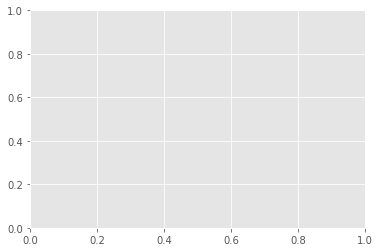

In [ ]:
%matplotlib inline
#import matplotlib.pyplot as plt
#print(H.history["loss"])
#N = np.arange(0,  NUM_EPOCHS)
#print(N)
#plt.plot(N,H.history["loss"])
import matplotlib.pyplot as plt
import numpy as np

N = np.arange(0,  NUM_EPOCHS)
plt.style.use("ggplot")
fig = plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# 11. Observing the Results

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(testX[i], cmap=plt.cm.binary)
    if testY[i][0] == 1:
      if predictions[i][0] > 0.5:
        plt.xlabel("Non-Fire", color='green')
      else:
        plt.xlabel("Non-Fire", color='red')
    else:
      if predictions[i][1] > 0.5:
        plt.xlabel("Fire", color='green')
      else:
        plt.xlabel("Fire", color='red')

plt.show()

# Saving the Model

In [ ]:
pip install -q pyyaml h5py

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model1.h5')


In [ ]:
!cp "/content/saved_model/my_model1.h5" -r "/content/drive/My Drive/SavedModels/2017EE193(2).h5"

# Model Loading

In [ ]:
#Loading the previous model
!cp "/content/drive/My Drive/SavedModels/Post9723.h5" -r "/content/my_model1"

In [ ]:
new_model = tf.keras.models.load_model('my_model1')

In [ ]:
model=new_model

Test Data Checking

In [ ]:
!unzip -q /content/drive/'My Drive'/'FinalTest.zip' -d Testing

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import argparse
CLASSES = ["Non-Fire", "Fire"]

print("[INFO] loading data...")
fireData1 = load_dataset( '/content/Testing/FinalTest/fire')
print("[INFO] Completed")
nonFireData1 = load_dataset( '/content/Testing/FinalTest/nonfire')
print("[INFO] Completed")
# construct the class labels for the data
fireLabels1 = np.ones((fireData1.shape[0],))
nonFireLabels1 = np.zeros((nonFireData1.shape[0],))
# stack the fire data with the non-fire data, then scale the data
# to the range [0, 1]
data1 = np.vstack([fireData1, nonFireData1])
labels1 = np.hstack([fireLabels1, nonFireLabels1])



data1 /= 255
# perform one-hot encoding on the labels and account for skew in the
# labeled data
labels1 = to_categorical(labels1, num_classes=2)

[INFO] loading data...
[INFO] Completed
[INFO] Completed


In [ ]:
np.shape(data1)


In [ ]:
print("[INFO] evaluating network...")
predictions = model.predict(data1, batch_size= 64)
print(classification_report(labels1.argmax(axis=1),
	predictions.argmax(axis=1), target_names= CLASSES))

In [ ]:
model.evaluate(data1,labels1)

In [ ]:
!cp "/content/drive/My Drive/Home" -r "/content/Test"

In [ ]:
fire1 = cv2.imread('/content/Test/f1.jpg')
fire1 = cv2.resize(fire1, (128,128))

fire2 = cv2.imread('/content/Test/f2.jpg')
fire2 = cv2.resize(fire2, (128,128))

non= cv2.imread('/content/Test/Non.jpg')
non= cv2.resize(non, (128,128))

In [ ]:
fire1=np.divide(fire1,255)
fire2=np.divide(fire2,255)
non=np.divide(non,255)

In [ ]:
fire1=np.expand_dims(fire1, axis=0)
fire1=np.array(fire1, dtype="float32")

fire2=np.expand_dims(fire2, axis=0)
fire2=np.array(fire2, dtype="float32")

non=np.expand_dims(non, axis=0)
non=np.array(non, dtype="float32")

In [ ]:
np.shape(fire1)

(1, 128, 128, 3)

In [ ]:
fire1

array([[[0.00018454, 0.00016917, 0.00023068],
        [0.00016917, 0.00015379, 0.00019992],
        [0.00016917, 0.00015379, 0.0002153 ],
        ...,
        [0.00336794, 0.00347559, 0.00352172],
        [0.00327566, 0.00336794, 0.00344483],
        [0.0033218 , 0.00341407, 0.00347559]],

       [[0.00019992, 0.00018454, 0.00024606],
        [0.00016917, 0.00015379, 0.0002153 ],
        [0.00015379, 0.00013841, 0.00019992],
        ...,
        [0.00344483, 0.00352172, 0.00356786],
        [0.00329104, 0.00339869, 0.00344483],
        [0.00330642, 0.00339869, 0.00346021]],

       [[0.00015379, 0.00013841, 0.00018454],
        [0.00016917, 0.00015379, 0.00018454],
        [0.00013841, 0.00015379, 0.0002153 ],
        ...,
        [0.00339869, 0.00350634, 0.0035371 ],
        [0.00335256, 0.00346021, 0.00350634],
        [0.00336794, 0.00347559, 0.00352172]],

       ...,

       [[0.00084583, 0.00106113, 0.00103037],
        [0.00079969, 0.00101499, 0.00098424],
        [0.00086121, 0

In [ ]:
model(fire1)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.36242422, 0.6375758 ]], dtype=float32)>

In [ ]:
model.predict(non)

array([[9.9979335e-01, 2.0666784e-04]], dtype=float32)